In [1]:
import os
import sys

ROOT_DIR = os.path.abspath("__file__" + "/../../")
sys.path.insert(0, f"{ROOT_DIR}")

In [2]:
import numpy as np

spin_j = 6
env_name = f"single vertex spinfoam/j={float(spin_j)}"

mcmc_chains = np.load(f"{ROOT_DIR}/data/MCMC/{env_name}/mcmc_chains.npy")
# mcmc_masks = np.load(f"{ROOT_DIR}/data/MCMC/{env_name}/acceptance_masks.npy")
gfn_states = np.load(f"{ROOT_DIR}/data/GFN/{env_name}/terminal_states.npy")

In [3]:
def get_observables_over_time(grid_positions, spin_j, every_n_iterations=100, masks=None):
    n_iterations, _, grid_dim = grid_positions.shape
    
    n_samples = 0
    sum_observables = 0
    n_samples_used_over_time = []
    observables_over_time = []
    for i in range(0, n_iterations, every_n_iterations):
        if masks is not None:
            selected_positions = [
                pos[mask] for pos, mask in zip(
                    grid_positions[i:i+every_n_iterations], masks[i:i+every_n_iterations]
                )
            ]
        else:
            selected_positions = grid_positions[i:i+every_n_iterations]
            
        states = np.concatenate(selected_positions)

        n_samples += states.shape[0]
        obs = states*(states+1)/(2*spin_j*(spin_j+1)) - 1
        sum_observables += np.sum(obs[:, 0])

        n_samples_used_over_time.append(n_samples)
        observables_over_time.append(sum_observables/n_samples)

    return observables_over_time, n_samples_used_over_time

mcmc_observables_over_time, mcmc_n_t = get_observables_over_time(
    mcmc_chains, spin_j, every_n_iterations=100, 
#     masks=mcmc_masks
)
gfn_observables_over_time, gfn_n_t = get_observables_over_time(
    gfn_states, spin_j, every_n_iterations=100
)

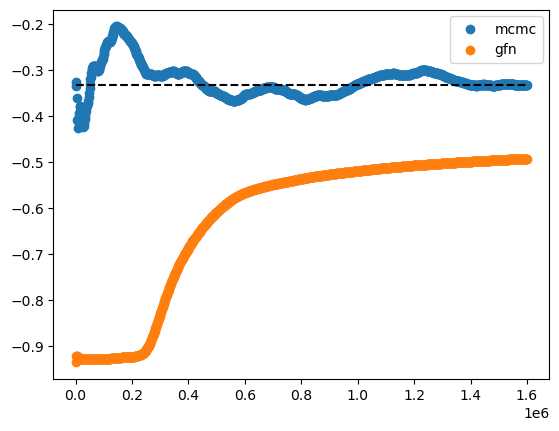

In [4]:
import matplotlib.pyplot as plt

plt.scatter(mcmc_n_t, mcmc_observables_over_time, label="mcmc")
plt.scatter(gfn_n_t, gfn_observables_over_time, label="gfn")
plt.hlines(-0.33333, gfn_n_t[0], gfn_n_t[-1], colors='k', linestyles='dashed')
plt.legend()

In [5]:
def get_distributions_over_time(grid_positions, grid_len, every_n_iterations=100, masks=None):
    n_iterations, _, grid_dim = grid_positions.shape

    counts = np.zeros(shape=(grid_len, )*grid_dim)
    n_samples = 0
    empirical_distributions_over_time = []
    n_samples_used_over_time = []
    for i in range(0, n_iterations, every_n_iterations):
        if masks is not None:
            selected_positions = [
                pos[mask] for pos, mask in zip(
                    grid_positions[i:i+every_n_iterations], masks[i:i+every_n_iterations]
                )
            ]
        else:
            selected_positions = grid_positions[i:i+every_n_iterations]
            
        states = np.concatenate(selected_positions)

        n_samples += states.shape[0]
        np.add.at(counts, tuple(states.T), 1)
        
        empirical_distributions_over_time.append(counts/n_samples)
        n_samples_used_over_time.append(n_samples)
    empirical_distributions_over_time = np.stack(empirical_distributions_over_time)
    return empirical_distributions_over_time, n_samples_used_over_time

grid_len = int(2*spin_j + 1)

mcmc_distributions_over_time, mcmc_n_t = get_distributions_over_time(
    mcmc_chains, grid_len, every_n_iterations=100, 
#     masks=mcmc_masks
)
gfn_distributions_over_time, gfn_n_t = get_distributions_over_time(
    gfn_states, grid_len, every_n_iterations=100
)

In [6]:
vertex = np.load(f"{ROOT_DIR}/data/EPRL_vertices/Python/Dl_20/vertex_j_{float(spin_j)}.npz")
sq_ampl = vertex**2
expected_distribution = sq_ampl / np.sum(sq_ampl)

In [7]:
def get_l1_errors(empirical_distributions_over_time, expected_distribution):
    l1_errors = np.abs(empirical_distributions_over_time - expected_distribution)
    
    grid_axes = empirical_distributions_over_time.ndim
    ave_error_over_time = np.mean(l1_errors, axis=tuple(range(1, grid_axes)))
    return ave_error_over_time

mcmc_l1_errors = get_l1_errors(mcmc_distributions_over_time, expected_distribution)
gfn_l1_errors = get_l1_errors(gfn_distributions_over_time, expected_distribution)

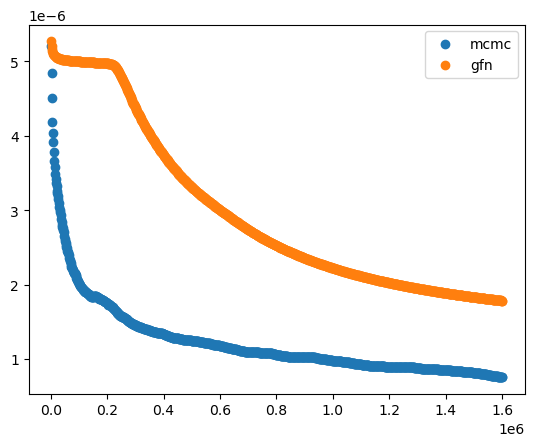

In [8]:
plt.scatter(mcmc_n_t, mcmc_l1_errors, label="mcmc")
plt.scatter(gfn_n_t, gfn_l1_errors, label="gfn")
plt.legend()

In [9]:
import numpy as np

grid_len = 64
grid_dim = 2
env_name = f"GFN Paper Grid Peaks/grid_length={grid_len}, grid_dim={grid_dim}"

mcmc_chains = np.load(f"{ROOT_DIR}/data/MCMC/{env_name}/mcmc_chains.npy")
# mcmc_masks = np.load(f"{ROOT_DIR}/data/MCMC/{env_name}/acceptance_masks.npy")
gfn_chains = np.load(f"{ROOT_DIR}/data/GFN/{env_name}/terminal_states.npy")

In [10]:
def get_distributions_over_time(grid_positions, grid_len, every_n_iterations=100, masks=None):
    n_iterations, _, grid_dim = grid_positions.shape

    counts = np.zeros(shape=(grid_len, )*grid_dim)
    n_samples = 0
    empirical_distributions_over_time = []
    n_samples_used_over_time = []
    for i in range(0, n_iterations, every_n_iterations):
        if masks is not None:
            selected_positions = [
                pos[mask] for pos, mask in zip(
                    grid_positions[i:i+every_n_iterations], masks[i:i+every_n_iterations]
                )
            ]
        else:
            selected_positions = grid_positions[i:i+every_n_iterations]
            
        states = np.concatenate(selected_positions)

        n_samples += states.shape[0]
        np.add.at(counts, tuple(states.T), 1)
        
        empirical_distributions_over_time.append(counts/n_samples)
        n_samples_used_over_time.append(n_samples)
    empirical_distributions_over_time = np.stack(empirical_distributions_over_time)
    return empirical_distributions_over_time, n_samples_used_over_time

mcmc_distributions_over_time, mcmc_n_t = get_distributions_over_time(
    mcmc_chains, grid_len, every_n_iterations=100, 
#     masks=mcmc_masks
)
gfn_distributions_over_time, gfn_n_t = get_distributions_over_time(
    gfn_chains, grid_len, every_n_iterations=100
)

In [11]:
from src.MCMC.MCMC import grid_rewards_2d

gfn_paper_rewards = grid_rewards_2d(grid_len)
expected_distribution = gfn_paper_rewards / np.sum(gfn_paper_rewards)

In [12]:
def get_l1_errors(empirical_distributions_over_time, expected_distribution):
    l1_errors = np.abs(empirical_distributions_over_time - expected_distribution)
    
    grid_axes = empirical_distributions_over_time.ndim
    ave_error_over_time = np.mean(l1_errors, axis=tuple(range(1, grid_axes)))
    return ave_error_over_time

mcmc_l1_errors = get_l1_errors(mcmc_distributions_over_time, expected_distribution)
gfn_l1_errors = get_l1_errors(gfn_distributions_over_time, expected_distribution)

(0.0, 5e-05)

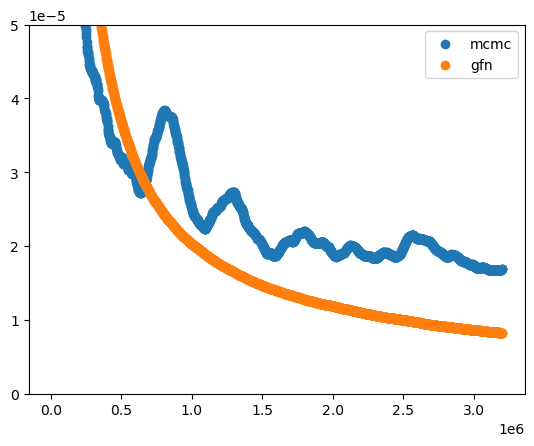

In [15]:
import matplotlib.pyplot as plt

plt.scatter(mcmc_n_t, mcmc_l1_errors, label="mcmc")
plt.scatter(gfn_n_t, gfn_l1_errors, label="gfn")
plt.legend()
plt.ylim(0, 5e-5)

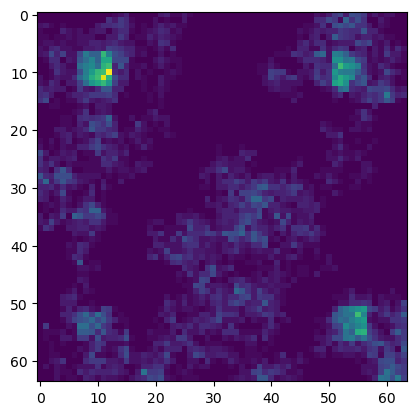

In [7]:
import matplotlib.pyplot as plt

# plt.imshow(gfn_distributions_over_time[-10])
plt.imshow(mcmc_distributions_over_time[5])